In [254]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets in the hub")
print(f"Here are the first 10: {all_datasets[:10]}")

There are 10000 datasets in the hub
Here are the first 10: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [255]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using the latest cached version of the module from /Users/petropolis/.cache/huggingface/modules/datasets_modules/datasets/emotion/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd (last modified on Mon Apr 10 02:52:09 2023) since it couldn't be found locally at emotion., or remotely on the Hugging Face Hub.


No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/petropolis/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [256]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [257]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [258]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [259]:
train_ds.column_names

['text', 'label']

In [260]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Podemos ver que o data type da coluna "text" é string, enquanto a coluna "label" é um objeto ClassLabel que contém informações sobre os nomes das classes e seus mapping para um valor inteiro

In [261]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [262]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

Nosso dataset real não estará no Hub, então precisaríamos carregá-lo de outra forma, felizmente o HuggingFace Dataset fornece uma forma fácil de carregar datasets localmente através da funcão:

load_dataset("csv", datafiles="my_file.csv")

Convenientemente o HugginFace fornece uma maneira de converter o formato de output do dataset. Vale ressaltar que isso não modifica o formato dos dados, só seu formato de exibição

In [263]:
import pandas as pd

emotions.set_format("pandas")
df = emotions["train"].to_pandas()
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
4,i am feeling grouchy,3


Como é bastante incoviniente lembrar qual número inteiro está associado a cada emoção, a label feature implementa também um método int2str para converter o inteiro para seu nome correspondente.

In [264]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

KeyboardInterrupt: 

É sempre uma boa ideia examinar a distribuição dos exemplos entre o dataset. Um dataset com uma distribuição enviesada pode precisar de um tratamento diferente em termos de traning loss e métricas de evaluation comparado a um dataset balanceado.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


counts = df["label_name"].value_counts(ascending=True)

In [ ]:
counts

label_name
surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: count, dtype: int64

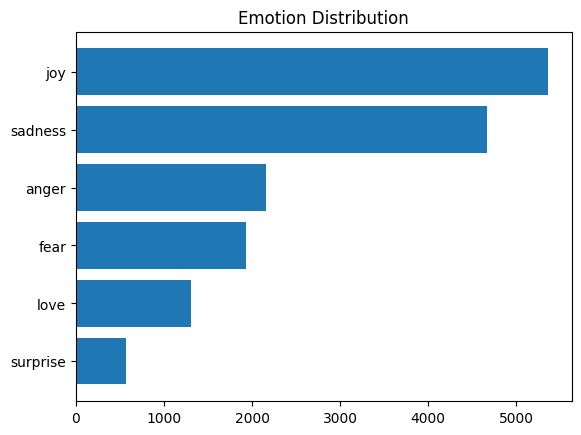

In [ ]:
plt.barh(counts.index, counts.values)
plt.title("Emotion Distribution")
plt.show()

Podemos ver que o dataset está pesadamente desbalanceado. As classes "joy" and "sadness" aparecerem frequentemente, enquanto "love" e "surprise" são cerca de 5 a 10 vezes mais raras.
Existem diversas maneiras de lidar com datasets desbalanceados, incluindo:

- Sobreamostrar aleatoriamente as classes minoritárias.
- Subamostrar aleatoriamente as classes majoritárias.
- Reunir mais dados rotulados das classes subrepresentadas.

Por agora iremos trabalhar com o dataset desbalanceado, porém iremos revisitar esse ponto no futuro.

# O quão longo são nossos tuítes?

Os modelos que implementam Transformers tem um máximo de sequência de input que é conhecido como _maxium context size_, para aplicações que implementam o DistilBERT, o _maximum context size_ é de 512 tokens, que somam alguns parágrafos de texto. Mais para frente iremos discutir o que são tokens, mas por agora podemos considerar 1 token = 1 char.

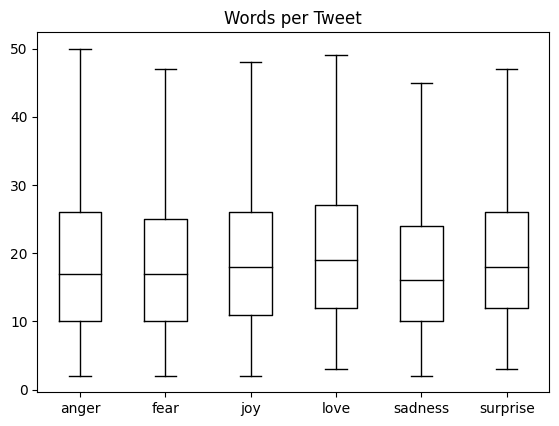

In [ ]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot(column="Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Pelo plot podemos observar que para cada emoção, cada tuíte contém por volta de 15 palavras, e os tuítes mais longos estão bem abaixo do limite do DistilBERT. Textos que são maiores que o _maximum context size_ de um modelo precisam ser truncados, o que pode levar a uma perda de performance se o texto truncado conter informações cruciais.

# Do texto para Tokens

Modelos que implementam Transformers como o DistilBERT não podem receber strings cruas como input. Esses modelos assumem que o texto foi tokenizado e encoded como vetores numéricos. Tokenizacão é o processo de quebrar as strings em unidades atômicas para serem usadas no modelo. Existem diversas estratégias de tokenização, e a melhor estratégia é geralmente aprendidada pelo corpus. Antes de olhar o tokenizador que é usado pelo distilbert, faremos um breve comentário sobre duas estratégias extremas de tokenização: "Character" e "Word" tokenization.

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Cada token foi mapeado para um identificador numérico. O último passo então é converter os inputs_ids para um tensor 2D de one-hot-vectors. One-hot vectors são frequentemente usados no mundo do machine learning para codificar dados de categoria, que podem ser ordinais ou nominais.

Supondo que a gente quisesse codificar os nomes das personagens do filme Transformers, uma maneira de fazer isso seria:

In [ ]:
categorical_df = pd.DataFrame(
 {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


O problema com esse approach é que cria uma ordem fictícia entre os nomes, e redes neurais são verdadeiramente muito boas em aprender esse tipo de relação. Então, criamos simplesmente uma nova coluna para cada categoria e atribuimos 1 onde a categoria é verdadeira, e 0 onde ela é falsa. No Pandas, isso pode ser implementado com auxílio da função get_dummies().

In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [ ]:
pd.get_dummies(categorical_df["Name"], dtype=int)

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

Para cada 38 tokens nós temos então um one-hot vector com 20 dimensões, pois nosso vocabulário contém 20 caractéres diferentes.

In [ ]:
import numpy as np
len(np.unique(input_ids))

20

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Subword Tokenization

A ideia por trás da Subword Tokenization é combinar os melhores aspectos da tokenização por character e por palavra. Por um lado, queremos quebrar palavras de baixa ocorrência em unidades menores para que ele seja capaz de lidar com palavras complexas e erros de ortografia. Por outro lado, queremos manter palavras frequentes como entidades únicas para manter o tamanho do vocabulário em um tamanho gerenciável. A maior característica dessa estratégia é que ela é **aprendida** com pretraining corpus.

Existem diversos algorítmos de subword tokenization que são usados dentro do universo da NLP, iremos ver o WordPiece, que é implementado pelo tokenizador do BERT e do DistilBERT

In [ ]:
# Felizmente o Hugging Face implementa uma classe AutoTokenizer
# que pertence a um conjunto de classes "automaticas" cujo trabalho
# é recuperar a configuração do modelo, pesos do pretreino, ou o vocabuláro pelo nome do checkpoint.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
encoded_text = tokenizer(text) # text = "Tokenizing text is a core task of NLP."
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Assim como a tokenização por char, podemos ver que as palavras foram mapeadas para inteiros únicos no campo __input_ids__. Iremos discutir sobre o papel do attention_mask posterioemente, mas guardem por enquanto essa ideia.

Agora que temos os inputs_ids, podemos convertê-los novamente para tokens usando o método convert_ids_to_tokens implementado pelo tokenizer.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

_CLS_ indica o **começo** de uma uma sequência.  
_SEP_ indica o **final** de uma sequência.  
Esses tokens geralmente variam de modelo para modelo.

Podemos ver que tokenizing e NLP foram quebrados em substrings, o que faz sentidos pois são palavras de ocorrência mais baixa. O prefixo ## indica que a sequência precedência não é um espaço em branco, quaisquer tokens com esse prefixo devem ser mergeados com o token anterior quando forem convertidos em string novamente.

In [ ]:
# A classe AutoTokenizer também possui um método convert_tokens_to_string que converte os tokens em uma string.
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

É muito importante quando usarmos pretrained models termos certezas que usamos também o mesmo tokenizador cujo modelo foi treinado. Para o modelos, mudar o tokenizador é como mudar o vocabulário.

# Tokenizing the Whole Dataset

In [ ]:
def tokenize(batch):
 return tokenizer(batch["text"], padding=True, truncation=True)

# padding=True will pad the sequences to the maximum length
# truncation=True will truncate the sequences to the models maximum length

In [ ]:
from datasets import load_dataset

emotions2 = load_dataset("emotion")

Using the latest cached version of the module from /Users/petropolis/.cache/huggingface/modules/datasets_modules/datasets/emotion/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd (last modified on Mon Apr 10 02:52:09 2023) since it couldn't be found locally at emotion., or remotely on the Hugging Face Hub.
No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/petropolis/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenize(emotions2["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
emotions["train"][:2]

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0


Aqui podemos ver o resultado do padding, o primeiro elemento dos inputs_ids é bem menor que o segundo, então zeros foram adicionados para assegurar que ambos tenham o mesmo tamanho. Também note que tokenizer retornou um attention_mask array. Isso é porque não queremos que o modelo se confunda com os paddings, a attention mask permite que o modelo ignore as padded partes do input.

In [ ]:
emotions_encoded = emotions2.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /Users/petropolis/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-12e3678e3ca4c1ad.arrow
Loading cached processed dataset at /Users/petropolis/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-19d4f572a6e262e1.arrow
Loading cached processed dataset at /Users/petropolis/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-83689b94c3128859.arrow


In [ ]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [ ]:
emotions_encoded["train"][0]["input_ids"]

[101,
 1045,
 2134,
 2102,
 2514,
 26608,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
emotions_encoded["train"][0]["attention_mask"]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

# Treinando um Classificador de Texto


Como vimos, modelos como o DistilBERT são pretreinados para predizer palavras mascaradas na sequência de um texto. Entretanto, não podemos usar esses modelos diretamente para classificação de texto, precisamos modificá-los levemente. Para entender como essa modificação, vamos voltar para o slide.

# Transformers como Feature Extractor

Mais uma vez, iremos usar a classe Auto do HuggingFace chamada AutoModel.  
Essa classe implementa um método chamado from_pretrained que carrega os pesos do modelo pre-treinado.

In [ ]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # usamos o PyTorch para checar se há uma GPU disponível
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


A classe AutoModel converte os token encodings para token embeddings e, em seguida, alimenta-os através do encoder stack para produzir hidden states. O objetivo é extrair os states do nosso corpus.

Vamos recuperar um hidden state de uma única string. A primeira coisa que precisamos fazer é realizar o encode dessa string e converter o o token para tensores do PyTorch, isso é facilmente feito passando o argumento return_tensors="pt" para o tokenizador, como demonstrado:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].shape}")

Input tensor shape: torch.Size([1, 6])


Como podemos ver, o tensor resultante tem a dimensão "batch_size, n_tokens". Agora que temos os encodings como um tensor, o passo final é colocá-lo no mesmo decive do modelo e passar os inputs.

In [ ]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
  print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


Nós usamos o gerenciador de context torch.no_grad() para disabilitar o cálculo do gradiente. O cálculo de gradientes é necessário durante a etapa de treinamento para atualizar os pesos do modelo com base no erro de previsão. Durante a inferência, o modelo já foi treinado então não é necessário atualizar os pesos.

No nosso exemplo, o output é uma instância do BaseModelOutput, e nós podemos accesar seus atributos pelo nome. O atual modelo retornou apenas um atributo, que é o hidden statek, então vamos examinar suas dimensões.

In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Observando o tensor hidden state, vemos que suas dimensões são [batch_size, n_tokens, hidden_dim]. Em outras palavras, um vetor de dimensão 768 é retornado para cada 6 tokens input tokens. Para tarefas de classificação é uma prática comum usar só o hidden state ssociado com o token [CLS] como input feature. Como esse token aparece no começo de cada sequência, nós podemos extraí-lo simplesmente indexando da seguinte forma:

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Agora que sabemos como extrair o hidden_state de uma única string, vamos fazê-lo para todo dataset.

In [ ]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names} # extrai os hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # retorna o vetor para o token [CLS]
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Como nosso modelo espera tensores como input, o próximo passo é converter os inputs_ids e attention_mask para o formato torch, como o seguinte:

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Agora podemos extrair todos os hidden_states

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

O extract_hidden_states adicionou uma coluna "hidden_state" ao nosso dataset.

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Criando uma matriz de features

O dataset pre-processado agora contem todas as informações que precisamos para treinar um classificador. Nós iremos usar os hidden states como input features e os labels como targets. Nós podemos criar os arrays correspondentes facilmente no formato do Scikit-learn, segue:

In [ ]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

É uma boa prática visualizar os dados que iremos classificar. Como visualizar hidden states em 768 dimensões não é possível, podemos usar um algorítmo chamado UMAP para criar projeções desses espaços vetorais num subespaço 2D. Como o UMAP funciona melhor quando as features estão dimensionadas para ficar no intervalo de [0, 1], primeiramente iremos aplicar o MinMaxScaler, e depois usar a implementação do UMAP para projetar os hidden states num espaço vetorial 2D.

In [ ]:
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled) # Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/Users/petropolis/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/petropolis/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/petropolis/Library/Python/3.9/lib/python/site-packages/umap/distanc

,X,Y,label
0,4.326355,6.602766,0
1,-2.902249,5.921591,0
2,5.291926,3.367009,3
3,-2.361753,3.529143,2
4,-3.066310,3.757779,3


O resultado final é um array com o mesmo número de training samples, mas com 2 features ao invés das 768 que vimos anteriormente. Vamos agora investigar os dados comprimidos um pouco mais profundamente e plotar a densidade de cada ponto de cada categoria separadamente.

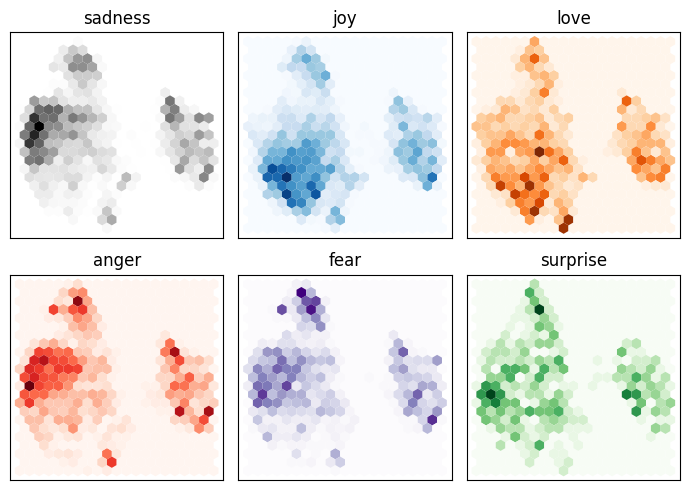

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],
                 cmap=cmap,
                 gridsize=20,
                 linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Só porque algumas categorias se sobrepõem no espaço 2D não significa que elas não são separadas no espaço original. Inversamente, se elas não se sobrepõem no espaço 2D, elas certamente não se sobrepoem no espaço original.  

Podemos ver que sadness, anger e fear ocupam regiões similares. Joy e Love também ocupam regiões similares, mas diferentes das emoções "negativas", já Surprise está em todas as regiões.

Agora vamos treinar um modelo de regressão linear para classificar os hiden_states.

In [ ]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

Olhando para a acurácia, aparentemente nosso modelo é só um pouco melhor do que aleatório, mas como estamos lidando com um dataset de várias classes e desbalanceado, na verdade é significamente melhor. Podemos confirmar essa tese comparando com um baseline simples. Dentro do sckit-learn, existe uma classe DummyClassifier que pode ser importado para criar um classificador com heurísticas simples, como escolher a classe majoritária ou classes aleatórias. Nesse caso, a melhor heurística é escolher sempre a classe mais frequente, que retorna uma acurácia de 35%.

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Então nosso classificador simples usando os embeddings do DistilBERT é significamente melhor que nossa baseline. Podemos investigar mais profundamente a performance do modelo plotando a matriz de confusão do classificador, que nos diz a relação entre os labels verdadeiros e o preditos.

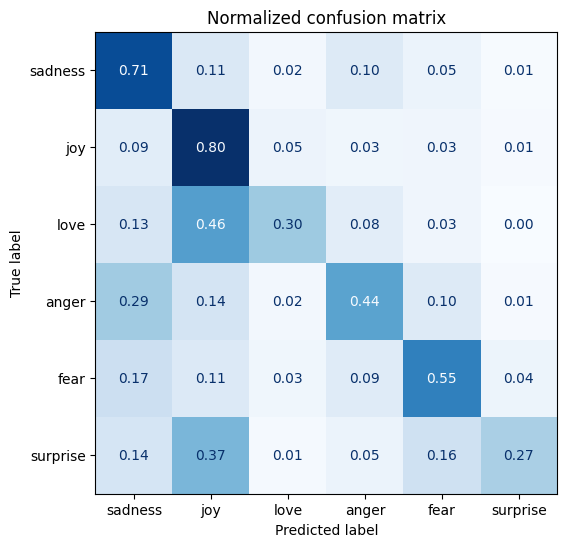

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Poodemos ver que **anger** e **fear** são constamente confundidos com **sadness**, o que reforça nossa observação quando visualizamos os embeddings. **love** e **surprise** são também confudidos com **joy**.

## Fine tuning Transformers

Nós usamos `AutoModelForSequenceClassification` ao invés do `AutoModel` pois o `AutoModelForSequenceClassification` tem um Classification Head em cada output pre treinado.

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
          .from_pretrained(model_ckpt, num_labels=num_labels)
          .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

### Defining the performance metrics

Vamos definir um monitoramento de métricas durante o treino. Para isso, criamos a função compute_metrics que recebe um objeto EvalPrediction (tupla com predictions e os atributos dos labels_ids) e retorna um dicionário que mapeia cada nome da métrica para seu valor. Para nossa aplicação, vamos computar o F1-score (média harmonica entre precisão e recall, varia de 0 a 1, f1 mais próximo de 1 indica um modelo perfeito)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/Users/petropolis/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8649, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3309759795665741, 'eval_accuracy': 0.896, 'eval_f1': 0.8923349868245531, 'eval_runtime': 170.7009, 'eval_samples_per_second': 11.716, 'eval_steps_per_second': 0.187, 'epoch': 1.0}
{'loss': 0.2582, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.22160272300243378, 'eval_accuracy': 0.9225, 'eval_f1': 0.9226803240287795, 'eval_runtime': 168.6891, 'eval_samples_per_second': 11.856, 'eval_steps_per_second': 0.19, 'epoch': 2.0}
{'train_runtime': 11615.3931, 'train_samples_per_second': 2.755, 'train_steps_per_second': 0.043, 'train_loss': 0.5615316925048828, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5615316925048828, metrics={'train_runtime': 11615.3931, 'train_samples_per_second': 2.755, 'train_steps_per_second': 0.043, 'train_loss': 0.5615316925048828, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
preds_output.metrics

{'test_loss': 0.22160272300243378,
 'test_accuracy': 0.9225,
 'test_f1': 0.9226803240287795,
 'test_runtime': 163.5657,
 'test_samples_per_second': 12.228,
 'test_steps_per_second': 0.196}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

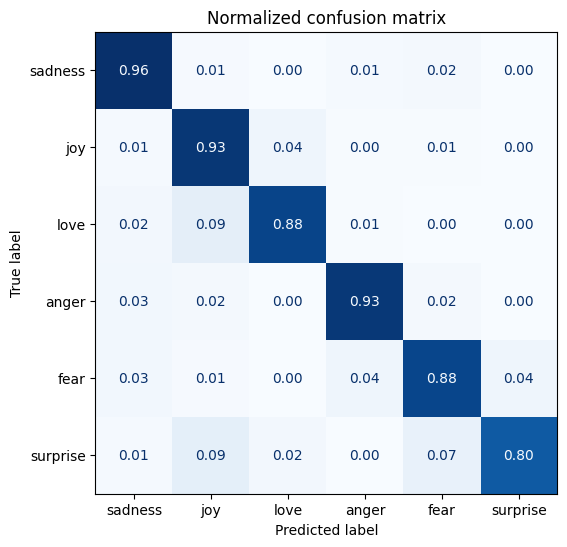

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Error analysis 

O objetivo de analisar os erros é determinar Wrong Labels e Peculiaridades do Dataset que estejam influenciando negativamente no classificador.

In [ ]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
# Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

Usando o map nós podemos aplicar essa função para pegar as losses para todas as nossas samples.

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Finalmente criamos um DataFrame com os textos, losses, e predict/true labels.

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
pd.set_option("display.max_colwidth", None)
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
1274,i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate,joy,sadness,5.759781
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,5.590810
765,i feel super awkward and out of place right now,joy,sadness,5.583248
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.528235
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.199363
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,5.187963
465,i would eventually go in to these stores but i had to work up a lot of courage and i would still feel super uncomfortable once inside which we all know is not normal for me,joy,fear,4.888491
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,4.687914
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,4.654274
312,i like the domestic scene salty sweet combos recipe reviews the smell of rosemary babies the feeling of having exercised hand clapping rhymes books lost teacups and laundry that has been washed dried folded and put away,sadness,joy,4.445344


Podemos ver claramente que o modelo classificou alguns dos labels incorretamente. Por outro lado, ainda parece que tem alguns exemplos sem uma classe muito clara, que pode ter sido mislabeled ou talvez precise de uma nova classe. Em particular, Joy parece ter sido mislabeled várias vezes.

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1137,i think i may be feeling sociable,joy,joy,0.016462
1884,i don t exactly feel sociable still,joy,joy,0.016577
4,i can have for a treat or if i am feeling festive,joy,joy,0.016694
1154,i love feeling carefree and without all these nervous feelings shooting through my body like i just saw myself on americas most wanted,joy,joy,0.016849
723,i was able to go to a st party i am back feeling sociable and i really hope to get back into going to the munch but that requires a walk a min bus journey another walk then the munch and then all that back again which at the moment is a little too much,joy,joy,0.017020
1873,i feel practically virtuous this month i have not exceeded my target of only buying things,joy,joy,0.017113
1020,i feel that the content i have in mind isnt really that great after all,joy,joy,0.017116
1622,i feel that it was a good investment to make this building into a restaurant,joy,joy,0.017135
19,i had lunch with an old friend and it was nice but in general im not feeling energetic,joy,joy,0.017255
1976,i trust heavily when i feel that the trust is worthwhile,joy,joy,0.017419


Podemos ver que nos menores losses o modelo parece ter sido bem confiante quanto a sadness. Modelos de deep learning são bons em tentar achar corta caminhos para retornar um output.  
Sabendo que Joy e Sadness levantam esses pontos, podemos tomar atitudes para melhorar nosso dataset.

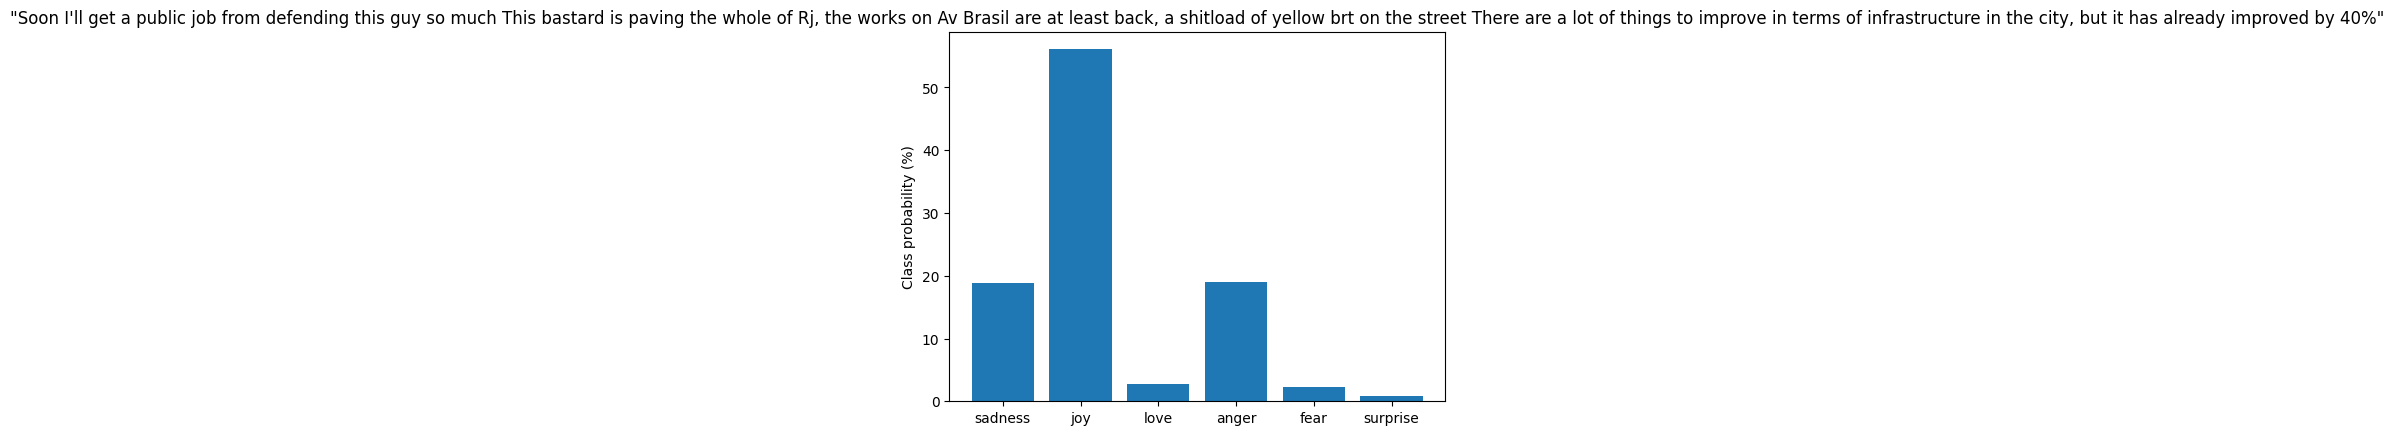

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

custom_text = "Soon I'll get a public job from defending this guy so much This bastard is paving the whole of Rj, the works on Av Brasil are at least back, a shitload of yellow brt on the street There are a lot of things to improve in terms of infrastructure in the city, but it has already improved by 40%" # elon musks tweet
preds = classifier(custom_text, return_all_scores=True)

preds_df = pd.DataFrame(preds)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()

In [ ]:
tweets_df = pd.read_excel("brt_amarelo.xlsx")

#remover duplicados
tweets_df.drop_duplicates(subset=['content'], inplace=True)

#vamos definir que os tweets com mais likes sao os mais levantes
tweets_df.sort_values("likes", ascending=False).head(10)

tweets_df.shape

(149, 16)

In [ ]:
from google.cloud import translate_v2 as translate

translate_client = translate.Client.from_service_account_json("tribal-pad-390501-ee1f8f9225cb.json")

def translate_text(text, target="en"):
  if isinstance(text, bytes):
    text = text.decode("utf-8")
  result = translate_client.translate(text, target_language=target)
  return result["translatedText"]

tweets_df["content_en"] = tweets_df["content"].apply(translate_text)

In [ ]:
tweets_df.head()

,tweet_id,username,name,profile_picture,replies,retweets,likes,is_retweet,posted_time,content,hashtags,mentions,images,videos,tweet_url,link,content_en
0,1630963373234876416,igordosus,Igor do SUS,https://pbs.twimg.com/profile_images/1598351115694874625/TkSni6sH_bigger.jpg,56,109,1366.0,False,2023-03-01 13:09:04,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO",[],[],[],[],https://twitter.com/igordosus/status/1630963373234876416,NaN,"People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway &quot;closing door&quot;. It seems that they added a new line (38) that goes only to Fundão too. FUCK, I&#39;M SHOCKED"
1,1648732790874054656,diesonnenlicht,Curadora de Diversidade da Farofa,https://pbs.twimg.com/profile_images/1646615495330725888/WYxxw5pL_bigger.jpg,3,5,18.0,False,2023-04-19 13:58:23,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,[],[],['https://pbs.twimg.com/ext_tw_video_thumb/1648732688960847872/pu/img/G3YBcp-nJe737Bjt.jpg'],['blob:https://twitter.com/dedeaaee-43b0-4b46-954a-7f5bafdbc1cb'],https://twitter.com/diesonnenlicht/status/1648732790874054656,NaN,A minute of silence to appreciate the superiority of the yellow BRT.
2,1653372392872329216,naoculpeopedro,incidente fecal no sbt,https://pbs.twimg.com/profile_images/1665218822314311681/pSU4JuwV_bigger.jpg,2,1,10.0,False,2023-05-02 09:14:31,ele chegou\n\no BRT amarelo chegou na zona oeste,[],[],['https://pbs.twimg.com/media/FvH1bOnXsAA1TOX?format=jpg&name=small'],[],https://twitter.com/naoculpeopedro/status/1653372392872329219,NaN,he arrived the yellow BRT arrived in the west zone
3,1641951081759404032,naoculpeopedro,incidente fecal no sbt,https://pbs.twimg.com/profile_images/1665218822314311681/pSU4JuwV_bigger.jpg,2,0,22.0,False,2023-03-31 20:50:18,como é bonito o BRT amarelo parabéns a todos,[],[],['https://pbs.twimg.com/media/FslhzXSXsAEnsgy?format=jpg&name=small'],[],https://twitter.com/naoculpeopedro/status/1641951081759404032,NaN,how beautiful is the yellow BRT congratulations to all
4,1630955804705652736,zwnetti,pedro,https://pbs.twimg.com/profile_images/1665938660494024704/O0gCcbn5_bigger.jpg,1,1,10.0,False,2023-03-01 12:39:00,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO",[],[],[],[],https://twitter.com/zwnetti/status/1630955804705652739,NaN,"I SAW A YELLOW BRT AT THE STATION OF OLARIA, I&#39;M NOT CRAZY"


In [ ]:

text = tweets_df.head()[["content", "content_en"]].values.tolist()[0]
print(f"Original text: {text[1]}")

Original text: People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway &quot;closing door&quot;. It seems that they added a new line (38) that goes only to Fundão too. FUCK, I&#39;M SHOCKED


In [ ]:
tweets_df_en = tweets_df[["username", "content", "content_en"]].copy()

tweets_df_en.head()

,username,content,content_en
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway &quot;closing door&quot;. It seems that they added a new line (38) that goes only to Fundão too. FUCK, I&#39;M SHOCKED"
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I&#39;M NOT CRAZY"


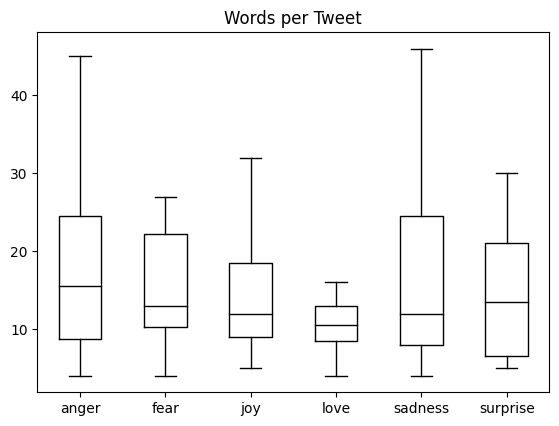

In [ ]:
df["Words per Tweet"] = tweets_df_en["content_en"].str.split().apply(len)
df.boxplot(column="Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
import html

def remove_html(text):
  return html.unescape(text)

tweets_df_en["content_en"] = tweets_df_en["content_en"].apply(remove_html)

In [ ]:
tweets_df_en.head()

,username,content,content_en
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED"
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY"


In [ ]:
def classify_text(text):
  preds = classifier(text, return_all_scores=True)
  return preds

tweets_df_en["preds"] = tweets_df_en["content_en"].apply(classify_text)

/Users/petropolis/Library/Python/3.9/lib/python/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [ ]:
tweets_df_en.head()

,username,content,content_en,preds
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED","[{'label': 'LABEL_0', 'score': 0.01208643987774849}, {'label': 'LABEL_1', 'score': 0.03583541512489319}, {'label': 'LABEL_2', 'score': 0.017782559618353844}, {'label': 'LABEL_3', 'score': 0.03202025219798088}, {'label': 'LABEL_4', 'score': 0.13683666288852692}, {'label': 'LABEL_5', 'score': 0.7654386758804321}]"
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.,"[{'label': 'LABEL_0', 'score': 0.00570283317938447}, {'label': 'LABEL_1', 'score': 0.9415447115898132}, {'label': 'LABEL_2', 'score': 0.036612723022699356}, {'label': 'LABEL_3', 'score': 0.005257464945316315}, {'label': 'LABEL_4', 'score': 0.0030774453189224005}, {'label': 'LABEL_5', 'score': 0.0078048123978078365}]"
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone,"[{'label': 'LABEL_0', 'score': 0.1383206993341446}, {'label': 'LABEL_1', 'score': 0.441482812166214}, {'label': 'LABEL_2', 'score': 0.02944326214492321}, {'label': 'LABEL_3', 'score': 0.19219377636909485}, {'label': 'LABEL_4', 'score': 0.16279572248458862}, {'label': 'LABEL_5', 'score': 0.03576365485787392}]"
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all,"[{'label': 'LABEL_0', 'score': 0.006498504430055618}, {'label': 'LABEL_1', 'score': 0.8433584570884705}, {'label': 'LABEL_2', 'score': 0.12388654798269272}, {'label': 'LABEL_3', 'score': 0.006026086863130331}, {'label': 'LABEL_4', 'score': 0.004393021110445261}, {'label': 'LABEL_5', 'score': 0.01583748869597912}]"
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY","[{'label': 'LABEL_0', 'score': 0.024928903207182884}, {'label': 'LABEL_1', 'score': 0.028713634237647057}, {'label': 'LABEL_2', 'score': 0.008353550918400288}, {'label': 'LABEL_3', 'score': 0.20771729946136475}, {'label': 'LABEL_4', 'score': 0.6509366631507874}, {'label': 'LABEL_5', 'score': 0.07934996485710144}]"


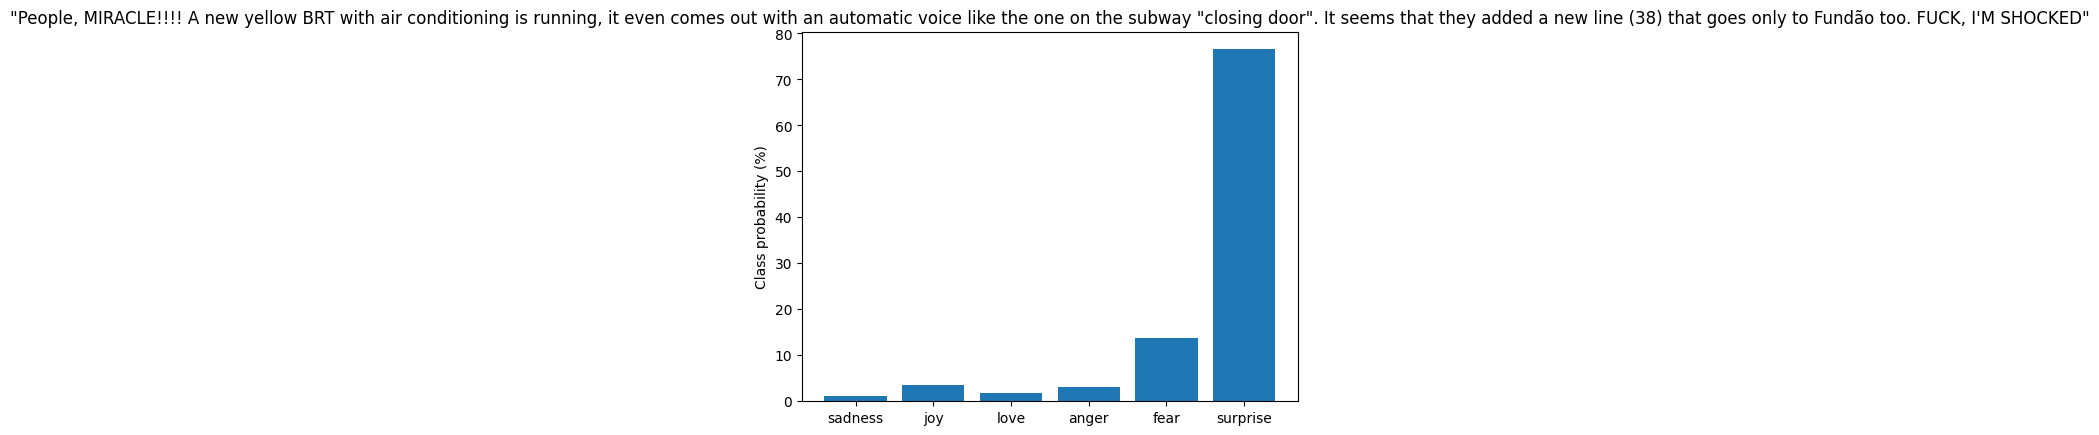

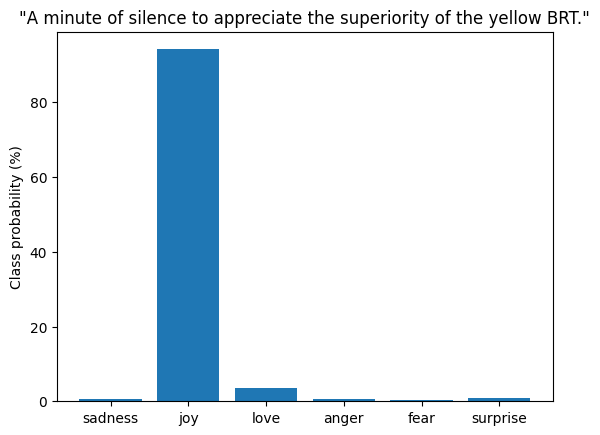

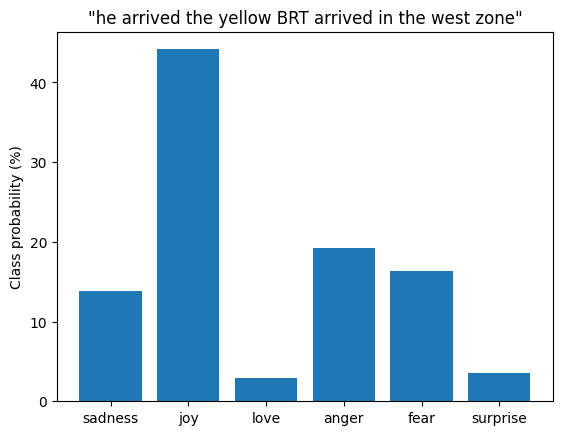

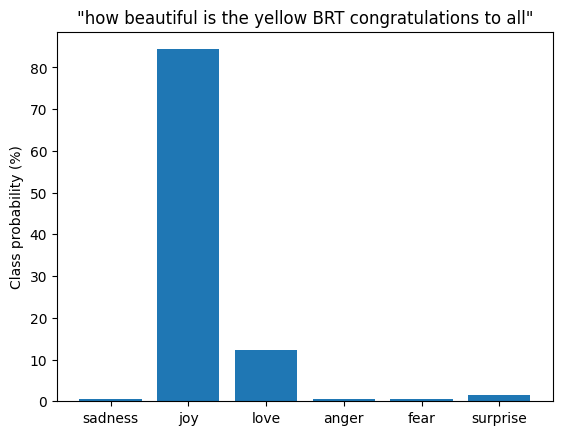

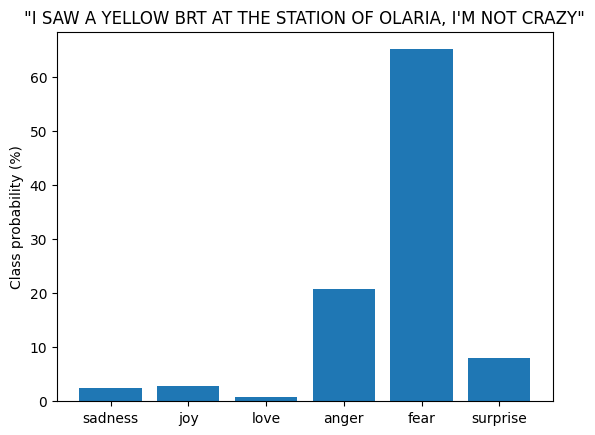

In [ ]:
preds = tweets_df_en["preds"].head().values.tolist()
content_en = tweets_df_en["content_en"].head().values.tolist()

for i, pred in enumerate(preds):
  preds_df = pd.DataFrame(pred)
  plt.bar(labels, 100 * preds_df["score"], color='C0')
  plt.title(f'"{content_en[i]}"')
  plt.ylabel("Class probability (%)")
  plt.show()

In [206]:
tweets_df_en["posted_time"] = tweets_df["posted_time"]

In [214]:
tweets_df_en

,username,content,content_en,preds,posted_time
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED","[{'label': 'LABEL_0', 'score': 0.01208643987774849}, {'label': 'LABEL_1', 'score': 0.03583541512489319}, {'label': 'LABEL_2', 'score': 0.017782559618353844}, {'label': 'LABEL_3', 'score': 0.03202025219798088}, {'label': 'LABEL_4', 'score': 0.13683666288852692}, {'label': 'LABEL_5', 'score': 0.7654386758804321}]",2023-03-01 13:09:04
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.,"[{'label': 'LABEL_0', 'score': 0.00570283317938447}, {'label': 'LABEL_1', 'score': 0.9415447115898132}, {'label': 'LABEL_2', 'score': 0.036612723022699356}, {'label': 'LABEL_3', 'score': 0.005257464945316315}, {'label': 'LABEL_4', 'score': 0.0030774453189224005}, {'label': 'LABEL_5', 'score': 0.0078048123978078365}]",2023-04-19 13:58:23
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone,"[{'label': 'LABEL_0', 'score': 0.1383206993341446}, {'label': 'LABEL_1', 'score': 0.441482812166214}, {'label': 'LABEL_2', 'score': 0.02944326214492321}, {'label': 'LABEL_3', 'score': 0.19219377636909485}, {'label': 'LABEL_4', 'score': 0.16279572248458862}, {'label': 'LABEL_5', 'score': 0.03576365485787392}]",2023-05-02 09:14:31
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all,"[{'label': 'LABEL_0', 'score': 0.006498504430055618}, {'label': 'LABEL_1', 'score': 0.8433584570884705}, {'label': 'LABEL_2', 'score': 0.12388654798269272}, {'label': 'LABEL_3', 'score': 0.006026086863130331}, {'label': 'LABEL_4', 'score': 0.004393021110445261}, {'label': 'LABEL_5', 'score': 0.01583748869597912}]",2023-03-31 20:50:18
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY","[{'label': 'LABEL_0', 'score': 0.024928903207182884}, {'label': 'LABEL_1', 'score': 0.028713634237647057}, {'label': 'LABEL_2', 'score': 0.008353550918400288}, {'label': 'LABEL_3', 'score': 0.20771729946136475}, {'label': 'LABEL_4', 'score': 0.6509366631507874}, {'label': 'LABEL_5', 'score': 0.07934996485710144}]",2023-03-01 12:39:00
...,...,...,...,...,...
231,pclages,"BRT amarelo é vida, isso não vai durar, infelizmente tenho certeza.","Yellow BRT is life, it won't last, unfortunately I'm sure.","[{'label': 'LABEL_0', 'score': 0.03049211949110031}, {'label': 'LABEL_1', 'score': 0.9182701110839844}, {'label': 'LABEL_2', 'score': 0.01373248640447855}, {'label': 'LABEL_3', 'score': 0.016767382621765137}, {'label': 'LABEL_4', 'score': 0.013403982855379581}, {'label': 'LABEL_5', 'score': 0.007334050256758928}]",2022-09-29 17:49:15
232,AugustoLeticya,"e o BRT amarelo já está um inferno de lotado, filhas da puta","and the yellow BRT is already a hell of a lot, motherfuckers","[{'label': 'LABEL_0', 'score': 0.03415491804480553}, {'label': 'LABEL_1', 'score': 0.024094413965940475}, {'label': 'LABEL_2', 'score': 0.010394718497991562}, {'label': 'LABEL_3', 'score': 0.9052895903587341}, {'label': 'LABEL_4', 'score': 0.019685572013258934}, {'label': 'LABEL_5', 'score': 0.006380852311849594}]",2022-09-27 07:21:32
234,mateusfp98,O BRT amarelo é assustadoramente feio,The yellow BRT is frighteningly ugly,"[{'label': 'LABEL_0', 'score': 0.6694991588592529}, {'label': 'LABEL_1', 'score': 0.020426565781235695}, {'label': 'LABEL_2', 'score': 0.009551558643579483}, {'label': 'LA

In [226]:
def get_pred_label(preds):
  arr = preds
  label_value = max(arr, key=lambda x: x['score'])['label']
  label_index = [i for i, d in enumerate(arr) if d['label'] == label_value][0]
  return labels[label_index]

tweets_df_en["pred_label"] = tweets_df_en["preds"].apply(get_pred_label)


In [229]:
tweets_df_en.head()

,username,content,content_en,posted_time,pred_label
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED",2023-03-01 13:09:04,surprise
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.,2023-04-19 13:58:23,joy
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone,2023-05-02 09:14:31,joy
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all,2023-03-31 20:50:18,joy
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY",2023-03-01 12:39:00,fear


<Axes: ylabel='count'>

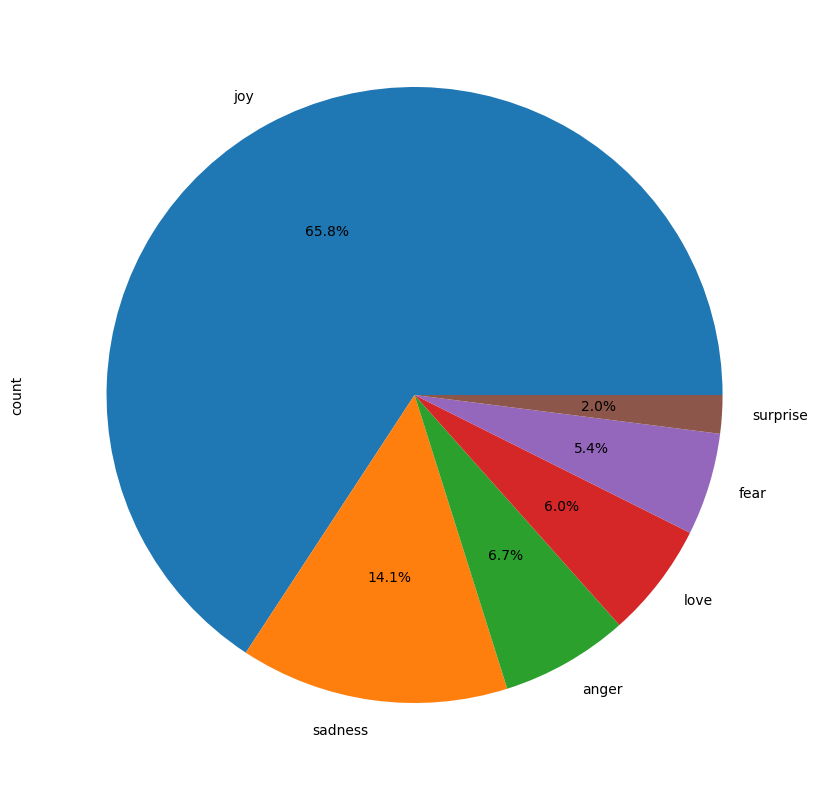

In [230]:
tweets_df_en["pred_label"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(10,10))

In [266]:
tweets_df_en

,username,content,content_en,posted_time,pred_label
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED",2023-03-01 13:09:04,surprise
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.,2023-04-19 13:58:23,joy
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone,2023-05-02 09:14:31,joy
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all,2023-03-31 20:50:18,joy
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY",2023-03-01 12:39:00,fear
...,...,...,...,...,...
231,pclages,"BRT amarelo é vida, isso não vai durar, infelizmente tenho certeza.","Yellow BRT is life, it won't last, unfortunately I'm sure.",2022-09-29 17:49:15,joy
232,AugustoLeticya,"e o BRT amarelo já está um inferno de lotado, filhas da puta","and the yellow BRT is already a hell of a lot, motherfuckers",2022-09-27 07:21:32,anger
234,mateusfp98,O BRT amarelo é assustadoramente feio,The yellow BRT is frighteningly ugly,2022-09-20 19:39:58,sadness
235,deyoldra,"Amg tu vai pra lá por qual região? Pq o BRT amarelo vai ser só parque olímpico e alvorada, 22 conto, tô pensando em ir de carro e deixar no metropolitano e ir andando msm, pq se o estacionamento pernoite for 45 conto, já vale a pena pq já dá a passagem de duas pessoas","Amg you go there for which region? because the yellow BRT will only be the olympic park and dawn, 22 contos, I'm thinking of going by car and leaving it on the subway and walking anyway, because if the overnight parking is 45 contos, it's already worth it because it already gives the passage of two people",2022-09-02 11:25:54,joy


In [268]:
tweets_df_from_human = pd.read_csv("tweets_df_from_human.csv")

In [275]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

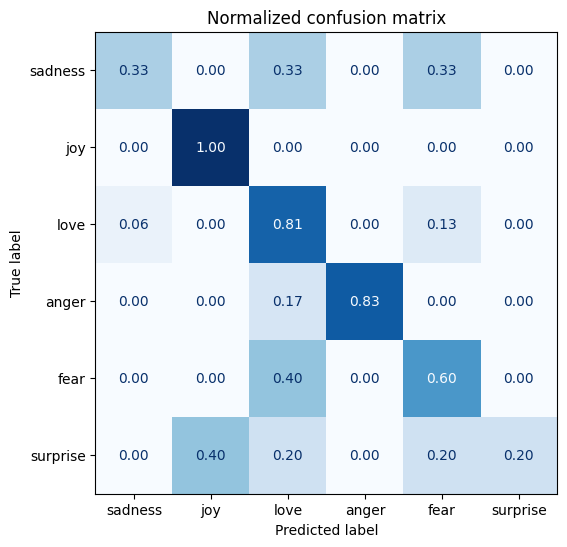

In [276]:
# get all "true_label" from dataset
true_labels = tweets_df_from_human["true_label"].values.tolist()
pred_labels = tweets_df_from_human["pred_label"].values.tolist()

plot_confusion_matrix(pred_labels, true_labels, labels)

In [278]:
tweets_df_from_human["pred_scores"] = tweets_df_from_human["content_en"].apply(classify_text)

/Users/petropolis/Library/Python/3.9/lib/python/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [295]:
def get_pred_label(preds):
  arr = preds
  pred_value = max(arr, key=lambda x: x['score'])
  label_value = pred_value['label']
  label_index = [i for i, d in enumerate(arr) if d['label'] == label_value][0]
  if(pred_value["score"]>0.85):
    return labels[label_index]
  else:
    return "None"

tweets_df_from_human["label_plus_85"] = tweets_df_from_human["pred_scores"].apply(get_pred_label)


In [297]:
tweets_df_from_human = tweets_df_from_human[tweets_df_from_human["label_plus_85"] != "None"]

In [310]:
true_labels = tweets_df_from_human["true_label"].values.tolist()
pred_labels = tweets_df_from_human["pred_label"].values.tolist()

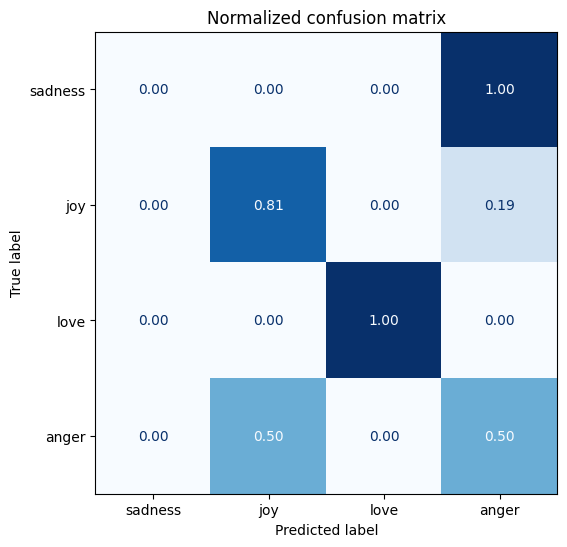

In [315]:
plot_confusion_matrix(pred_labels, true_labels, ["sadness", "joy", "love", "anger"])

In [353]:
tweets_df_en

,username,content,content_en,posted_time,pred_label
0,igordosus,"Gente, MILAGRE!!!!\n\nTá rodando um BRT amarelo novo com ar condicionado, sai até voz automática igual aquela do metrô ""porta de fechando"". Parece q adicionaram uma nova linha (38) q vai só até o Fundão tbm.\n\nCARALHO, EU TO CHOCADO","People, MIRACLE!!!! A new yellow BRT with air conditioning is running, it even comes out with an automatic voice like the one on the subway ""closing door"". It seems that they added a new line (38) that goes only to Fundão too. FUCK, I'M SHOCKED",2023-03-01 13:09:04,surprise
1,diesonnenlicht,Um minuto de silêncio para apreciarmos a superioridade do BRT amarelo.,A minute of silence to appreciate the superiority of the yellow BRT.,2023-04-19 13:58:23,joy
2,naoculpeopedro,ele chegou\n\no BRT amarelo chegou na zona oeste,he arrived the yellow BRT arrived in the west zone,2023-05-02 09:14:31,joy
3,naoculpeopedro,como é bonito o BRT amarelo parabéns a todos,how beautiful is the yellow BRT congratulations to all,2023-03-31 20:50:18,joy
4,zwnetti,"EU VI UM BRT AMARELO NA ESTAÇAO DE OLARIA, EU NAO TO MALUCO","I SAW A YELLOW BRT AT THE STATION OF OLARIA, I'M NOT CRAZY",2023-03-01 12:39:00,fear
...,...,...,...,...,...
231,pclages,"BRT amarelo é vida, isso não vai durar, infelizmente tenho certeza.","Yellow BRT is life, it won't last, unfortunately I'm sure.",2022-09-29 17:49:15,joy
232,AugustoLeticya,"e o BRT amarelo já está um inferno de lotado, filhas da puta","and the yellow BRT is already a hell of a lot, motherfuckers",2022-09-27 07:21:32,anger
234,mateusfp98,O BRT amarelo é assustadoramente feio,The yellow BRT is frighteningly ugly,2022-09-20 19:39:58,sadness
235,deyoldra,"Amg tu vai pra lá por qual região? Pq o BRT amarelo vai ser só parque olímpico e alvorada, 22 conto, tô pensando em ir de carro e deixar no metropolitano e ir andando msm, pq se o estacionamento pernoite for 45 conto, já vale a pena pq já dá a passagem de duas pessoas","Amg you go there for which region? because the yellow BRT will only be the olympic park and dawn, 22 contos, I'm thinking of going by car and leaving it on the subway and walking anyway, because if the overnight parking is 45 contos, it's already worth it because it already gives the passage of two people",2022-09-02 11:25:54,joy


In [357]:
tweets_df_en["posted_time_date_time"] = pd.to_datetime(tweets_df_en["posted_time"])

grouped_df = tweets_df_en.groupby([pd.Grouper(key="posted_time_date_time", freq="W"), "pred_label"]).size().reset_index(name="count")

grouped_df

,posted_time_date_time,pred_label,count
0,2022-09-04,joy,2
1,2022-09-25,sadness,2
2,2022-10-02,anger,2
3,2022-10-02,joy,1
4,2022-10-02,sadness,1
...,...,...,...
58,2023-05-21,sadness,1
59,2023-05-28,joy,2
60,2023-06-04,anger,1
61,2023-06-11,joy,1


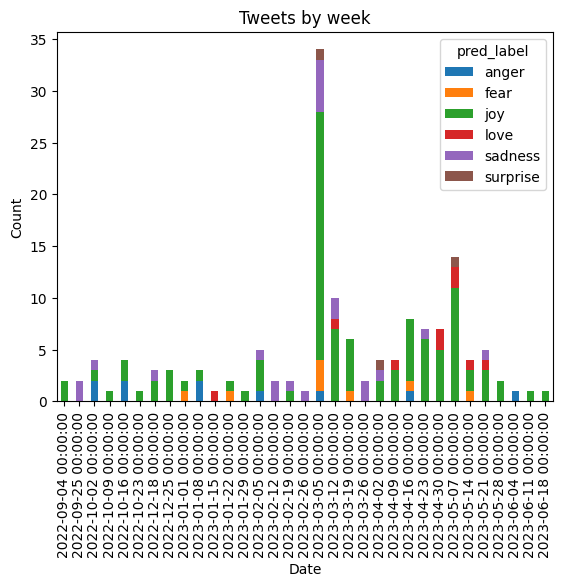

In [358]:
grouped_df['posted_time_date_time'] = pd.to_datetime(grouped_df['posted_time_date_time'])
grouped_df = grouped_df.groupby(['posted_time_date_time', 'pred_label'])['count'].sum().unstack()

grouped_df.plot(kind='bar', stacked=True)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Tweets by week')

plt.show()

Prefeitura do Rio entregou 110 onibus na semana do dia 03-05

https://www.eduardopaes.com.br/paes-entrega-mais-110-novos-onibus-do-brt-transcarioca-tem-frota-100-renovada/